In [97]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import ALookAtTheData as t
from IPython import display
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#read csv files from Kaggle for Boston listings
#https://www.kaggle.com/airbnb/boston?select=listings.csv
#NOTE: file renamed from listings.csv to boston_listings.csv
df_b_list = pd.read_csv('boston_listings.csv')
#df_b_list.head()

In [98]:
#code found on https://pbpython.com/currency-cleanup.html. converts price to float after removing $
#futurewarning about value of regex when runs but still produces results; 
#for the sake of timely completion of this assignment, will ignore error for now and make changes in the future as needed
df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")

<ipython-input-98-341bbc98973d>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_b_list['price'] = pd.to_numeric(df_b_list['price'].str.replace("$", "").str.replace(",", ""), errors = "ignore")


In [99]:
#sample larger values to ensure dollar sign and comma removed. price field also now float instead of object
df_b_list.price.loc[df_b_list['price'] > 999]

793     1400.0
1022    1300.0
1262    1250.0
1764    1000.0
1896    1235.0
1950    1345.0
2204    1372.0
2285    4000.0
2448    1275.0
3055    3000.0
3096    1250.0
3242    1000.0
Name: price, dtype: float64

In [100]:
#3,585 total records
df_b_list.shape

(3585, 95)

In [134]:
#dataframes for three questions/sets
df_1 = df_b_list[['price', 'bedrooms', 'bathrooms']] #question 1 and 2
df_3 = df_b_list[['price', 'neighbourhood_cleansed']] #question 3
df_4 = df_b_list[['room_type', 'calendar_updated', 'availability_90']] #question 4

In [102]:
####################################################
####################################################
####################################################
####################################################
#Question 1: Is number of of bathrooms closely related to listing price? what about number of bedrooms?

#check data types, set 1. Price set to Y; Bedrooms, Bathrooms, Beds set to X 
#Expect all datatypes as numeric/non-categorical. Checks out....
df_1.dtypes

price        float64
bedrooms     float64
bathrooms    float64
dtype: object

In [103]:
#stats on dataset. Small population size. Most units 1 bedroom, 1-2 bathrooms, 1 bed. small number of X values missing
#NOTE: I thought about concatenating bedrooms + bathrooms + beds into 1 categorical variable and using pandas.get_dummies(), 
#but the population is small (I didn't think this would be a good approach).
df_1.describe()

,price,bedrooms,bathrooms
count,3585.000000,3575.000000,3571.000000
mean,173.925802,1.255944,1.221647
std,148.331321,0.753060,0.501487
min,10.000000,0.000000,0.000000
25%,85.000000,1.000000,1.000000
50%,150.000000,1.000000,1.000000
75%,220.000000,2.000000,1.000000
max,4000.000000,5.000000,6.000000


In [104]:
#Price (Y) no nulls; X axis values show small number of null values, < 1%. However, dataset 3.5K (small set to begin with)
#Makes more sense to impute X values with mean so we do not lose value
(np.sum(df_1.isnull() == True)/df_1.shape[0])*100

price        0.000000
bedrooms     0.278940
bathrooms    0.390516
dtype: float64

In [105]:
#identify null bathroom rows (will check before/after rows filled with mean)
#check row 989 after
df_1[df_1['bathrooms'].isna()]

,price,bedrooms,bathrooms
103,85.0,1.0,NaN
630,35.0,1.0,NaN
755,99.0,1.0,NaN
800,167.0,1.0,NaN
820,60.0,1.0,NaN
825,60.0,1.0,NaN
888,163.0,1.0,NaN
910,53.0,1.0,NaN
989,98.0,1.0,NaN
1120,135.0,1.0,NaN


In [106]:
#identify null bedroom rows (will check before/after rows filled with mean)
#check row 918 after
df_1[df_1['bedrooms'].isna()]

,price,bedrooms,bathrooms
918,176.0,NaN,1.0
920,229.0,NaN,1.0
924,275.0,NaN,1.0
1095,186.0,NaN,1.0
1117,269.0,NaN,1.0
1132,225.0,NaN,1.0
1251,209.0,NaN,1.0
1366,209.0,NaN,1.0
1419,209.0,NaN,1.0
1959,175.0,NaN,1.0


In [107]:
# Fill null numeric columns with the mean.
# Ignore SettingWithCopyWarning code from stackoverflow:
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  
num_vars = df_1.select_dtypes(include=['float64', 'int']).columns
for col in num_vars:
    df_1a = df_1[col].fillna((df_1[col].mean()), inplace=True)

In [108]:
#validate nulls no longer exist (no nulls exist)
np.sum(df_1.isnull() == True)

price        0
bedrooms     0
bathrooms    0
dtype: int64

In [110]:
#spot check row 989 (null bathroom) is now filled with mean...checks out
df_1.loc[989]

price        98.000000
bedrooms      1.000000
bathrooms     1.221647
Name: 989, dtype: float64

In [111]:
#spot check row 918 (null bedroom) is now filled with mean ...checks out
df_1.loc[918]

price        176.000000
bedrooms       1.255944
bathrooms      1.000000
Name: 918, dtype: float64

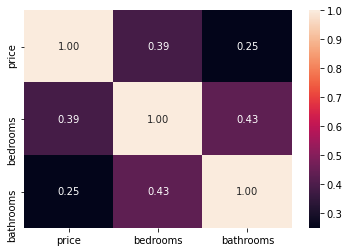

In [112]:
#Heatmap to show correlation of price to rooms
#higher correlation with price and bedrooms, lower correlation with bathrooms
sns.heatmap(df_1.corr(), annot=True, fmt=".2f");

In [113]:
#create model with several output sets for plotting. function modified from:
# https://github.com/udacity/DSND_Term2/blob/master/lessons/CRISP_DM/Categorical%20Variables%20-%20Solution.ipynb
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):


    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds


#create output sets
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds = clean_fit_linear_mod(df_1, 'price')

In [114]:
#training and testing score. R squared lower and not too far off between test and training data, 
#indicating overfitting is not happening
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.175399404110552.  The rsquared on the test data was 0.12728775019667382.


Coefficients:  [67.72241705 27.31573976]


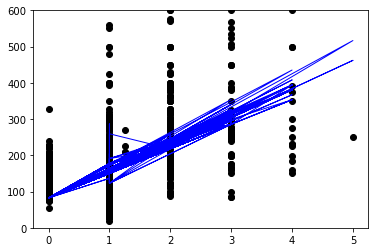

Text(0.5, 1.0, 'Price to # of Bedrooms Plot')

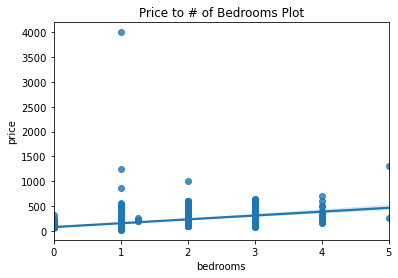

In [85]:
#Show coefficients and scatter plot (matplotlib and seaborn libraries) with number of bedrooms for X
#plot shows 1 extreme outlier, price = $4,000 ...I set the limit to 600 below with matplotlib

# coefficients
print('Coefficients: ', lm_model.coef_)

# Plot with matplotlib
plt.scatter(X_test['bedrooms'], y_test,  color='black') 
plt.plot(X_test['bedrooms'], y_test_preds, color='blue', linewidth=1)
plt.ylim(0, 600)
plt.show()

#plot with seaborn (looks cleaner)
sns.regplot(x=X_test['bedrooms'], y=y_test, truncate = True).set_title('Price to # of Bedrooms Plot')

Coefficients:  [67.72241705 27.31573976]


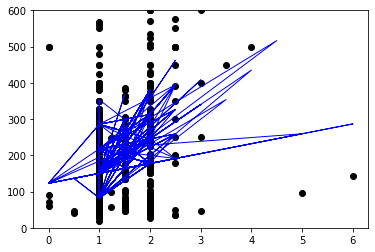

Text(0.5, 1.0, 'Price to # of Bathrooms Plot')

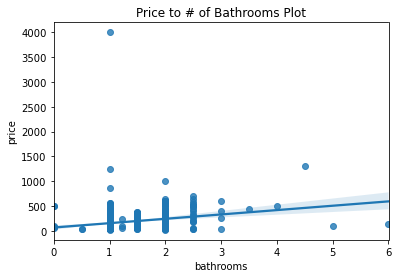

In [115]:
#Show coefficients and scatter plot (matplotlib and seaborn libraries) with number of bathrooms for X
# plot shows 1 extreme outlier, price = $4,000 ...I set the limit to 600 below with matplotlib

# coefficients
print('Coefficients: ', lm_model.coef_)

# Plot with matplotlib
plt.scatter(X_test['bathrooms'], y_test,  color='black') 
plt.plot(X_test['bathrooms'], y_test_preds, color='blue', linewidth=1)
plt.ylim(0, 600)
plt.show()

#plot with seaborn (looks cleaner)
sns.regplot(x=X_test['bathrooms'], y=y_test, truncate = True).set_title('Price to # of Bathrooms Plot')

In [116]:
#Conclusion Question 1: 
#positive relationship exists between increase in price and increase in bedrooms and bathrooms (linear plots).
#price more correlated to number of bedrooms, less correlated to number of bathrooms (heat map)
#coefficients are positive, indicating X and y variables both increase  (listed above)
#R squared not too far off between test and training data, indicating overfitting not an issue (listed above)
####################################################
####################################################
####################################################
####################################################
#END Question 1..........................................

In [117]:
####################################################
####################################################
####################################################
####################################################
#Question 2: Can we provide insight into how much a rental with a certain number of bedrooms/bathrooms should list?

#descriptive stats: plots from Question 1 do not display pricing well. need a table/chart to display exact amounts
df_1_mean= df_1.groupby(df_1.bedrooms) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by mean price highest to lowest
df_1_mean.sort_values("mean_price", ascending=False)

,mean_price,med_price,cnt_listings,min_price,max_price
bedrooms,,,,,
5.000000,429.000000,341.5,16,100.0,1300.0
4.000000,389.400000,375.0,45,115.0,750.0
3.000000,316.419355,279.0,155,84.0,1250.0
2.000000,258.753247,249.0,693,45.0,3000.0
1.255944,216.200000,209.0,10,175.0,275.0
0.000000,154.668990,150.0,287,55.0,450.0
1.000000,136.285834,103.0,2379,10.0,4000.0


In [118]:
#Question 2 analysis: 
# mean and median rental prices list in the chart above.
#NOTE: 0 bedroom rentals cost more than 1 bedroom. Sampling data from the .csv these are full studio apartment 
#rentals. Typically cost more than renting a single room, which makes sense. 
####################################################
####################################################
####################################################
####################################################
#End question 2

In [120]:
####################################################
####################################################
####################################################
####################################################
#Question 3: Can we provide Airbnb owners typical rental prices in different Boston neighborhoods?

#neighborhood_cleansed (neighborhood) field has no null values; will not need to remove nulls. 
(np.sum(df_3.isnull() == True)/df_3.shape[0])*100

price                     0.0
neighbourhood_cleansed    0.0
dtype: float64

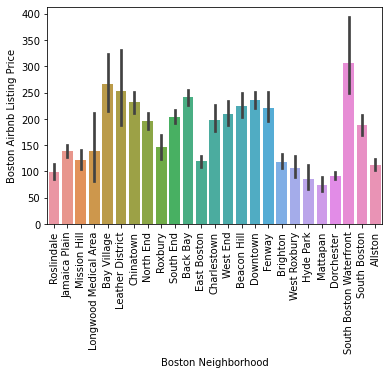

,mean_price,med_price,cnt_listings,min_price,max_price
neighbourhood_cleansed,,,,,
Leather District,253.600000,245.0,5,159.0,390.0
South Boston Waterfront,306.060241,245.0,83,115.0,3000.0
Downtown,236.459302,225.0,172,10.0,600.0
Chinatown,232.352113,219.0,71,80.0,399.0
Back Bay,240.950331,209.0,302,40.0,1250.0
Bay Village,266.833333,206.5,24,90.0,500.0
West End,209.591837,199.0,49,60.0,450.0
Beacon Hill,224.443299,195.0,194,75.0,1345.0
Fenway,220.393103,191.0,290,30.0,4000.0


In [121]:
#price per Boston neighborhood, seaborn barplot, unsorted
sns.barplot(x = 'neighbourhood_cleansed', y = 'price', data = df_3)
plt.ylabel('Boston Airbnb Listing Price')
plt.xlabel('Boston Neighborhood')
plt.xticks(rotation=90)
plt.show()

#descriptive stats
df_3_mean= df_2.groupby(df_3.neighbourhood_cleansed) \
.agg(
     mean_price=pd.NamedAgg(column='price', aggfunc='mean'), \
     med_price=pd.NamedAgg(column='price', aggfunc='median'), \
     cnt_listings=pd.NamedAgg(column='price', aggfunc='count'), \
     min_price=pd.NamedAgg(column='price', aggfunc='min'),  \
     max_price=pd.NamedAgg(column='price', aggfunc='max'),  \
    )
#sorted descriptive stats by median price highest to lowest (may be a better indicator of category (high to low) than mean)
df_3_mean.sort_values("med_price", ascending=False)

In [122]:
#Question 3 Analysis findings: 
#Outliers may skew results and should be careful when drawing conclusions:
#Example1: South Boston Waterfront mean price=$306 (highest) but median is $245. Max listing is $3,000, total listings 83.
    #High priced listing likely driving the mean much higher (mean could be closer to $250)
#Example2: Downtown has a min price of $10 (could be driving the average lower; could be an error in the listing)
#Example3: Leather district has 5 listings, but min listing still relatively high (may not be an issue) 
#Conclusion: using median price may be the best way to categorically rank area pricing from high to low (instead of mean price)
####################################################
####################################################
####################################################
####################################################
#END QUESTION 3..........................................

In [135]:
####################################################
####################################################
####################################################
####################################################
#QUESTION 4: Can we provide feedback on rental type demand (IE, are rooms/shared rooms/full units in higher demand)?

#no null values; will not need to remove nulls. 
(np.sum(df_4.isnull() == True)/df_4.shape[0])*100

room_type           0.0
calendar_updated    0.0
availability_90     0.0
dtype: float64

In [137]:
#3,585 total records
df_4.shape

(3585, 3)

In [138]:
#a smaller number of listings not updated in several months, some never updated. This may affect availability since 
#listings may be inaccurate or never used/under-utilized. We will remove listings not updated within 6 months
df_4.calendar_updated.value_counts(ascending=True)

30 months ago      1
20 months ago      1
23 months ago      1
22 months ago      1
25 months ago      2
18 months ago      2
16 months ago      7
15 months ago      8
17 months ago      9
12 months ago     13
11 months ago     17
14 months ago     19
13 months ago     19
never             19
8 months ago      32
6 months ago      32
9 months ago      35
6 days ago        36
1 week ago        36
10 months ago     37
7 weeks ago       37
7 months ago      43
5 months ago      56
6 weeks ago       81
4 months ago      85
2 days ago        98
3 days ago       101
5 weeks ago      128
3 months ago     131
5 days ago       132
4 weeks ago      158
2 months ago     165
4 days ago       168
yesterday        174
3 weeks ago      221
2 weeks ago      307
a week ago       340
today            833
Name: calendar_updated, dtype: int64

In [139]:
#create drop list and drop rows with older/missing calander_updated values
#code idea from https://www.codegrepper.com/code-examples/python/how+to+drop+rows+with+specific+value+in+pandas
drop_list = ['23 months ago','20 months ago','30 months ago','22 months ago','25 months ago','18 months ago','16 months ago','15 months ago','17 months ago','12 months ago','11 months ago','never','13 months ago','14 months ago','8 months ago','9 months ago','10 months ago','7 months ago']
df_4.drop(df_4.index[df_4['calendar_updated'].isin(drop_list)], inplace = True)

In [140]:
#verify list of values removed
df_4.calendar_updated.value_counts(ascending=True)

6 months ago     32
1 week ago       36
6 days ago       36
7 weeks ago      37
5 months ago     56
6 weeks ago      81
4 months ago     85
2 days ago       98
3 days ago      101
5 weeks ago     128
3 months ago    131
5 days ago      132
4 weeks ago     158
2 months ago    165
4 days ago      168
yesterday       174
3 weeks ago     221
2 weeks ago     307
a week ago      340
today           833
Name: calendar_updated, dtype: int64

In [141]:
#drop calendar_updated field (no longer needed)
df_4.drop('calendar_updated', axis=1, inplace=True)

In [129]:
#verify column dropped
df_4

,room_type,availability_90
0,Entire home/apt,0
1,Private room,84
2,Private room,61
3,Private room,26
4,Private room,59
...,...,...
3579,Private room,23
3580,Private room,81
3582,Entire home/apt,40
3583,Private room,5


In [142]:
#statistics for Question 4
df_4_mean= df_4.groupby(df_4.room_type) \
.agg(
    mean_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='mean'), \
     med_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='median'), \
     cnt_rentals=pd.NamedAgg(column='availability_90', aggfunc='count'), \
     min_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='min'),  \
     max_avail_90days=pd.NamedAgg(column='availability_90', aggfunc='max'),  \
     std_dev=pd.NamedAgg(column='availability_90', aggfunc='std'),
    )
#sorted by median price highest to lowest (may be a better indicator of category (high to low) than mean)
df_4_mean.sort_values("mean_avail_90days", ascending=False)

,mean_avail_90days,med_avail_90days,cnt_rentals,min_avail_90days,max_avail_90days,std_dev
room_type,,,,,,
Shared room,48.328767,57,73,0,90,35.878675
Entire home/apt,41.000500,41,2001,0,90,32.616323
Private room,39.404819,38,1245,0,90,32.001557


In [144]:
#Analysis of question 4: private rooms have the least days available in a 90 day period (lower median and mean availability)
#   Followed by Entire home/apt, followed by shared room (least demand)
# Entire homes/apt's and Private rooms have a healthy population size; shared rooms do not (may not be as reliable)
#private rooms standard deviation the lowest of three types, with data points clustered around the mean. 
# however, variation in standard deviation between the three sets is still quite similar
#CONCLUSION: we can assume private rooms are the most in demand room types for Airbnb listings in Boston
#shared rooms are least in demand for Airbnb listings in Boston
####################################################
####################################################
####################################################
####################################################
#END Question 4..........................................